## Assignment : 14

<pre>
1. Download the preprocessed DonorsChoose data from here <a href='https://drive.google.com/file/d/1GU3LIJJ3zS1xLXXe-sdItSJHtI5txjVO/view?usp=sharing'>Dataset</a>
2. Split the data into train, cv, and test
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric. you need to print the AUC value for each epoch. Note: you should NOT use the tf.metric.auc
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. You should Save the best model weights.
8. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
9. Use Categorical Cross Entropy as Loss to minimize.
10. try to get AUC more than 0.8 for atleast one model
</pre>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
%matplotlib inline
import re
import pickle
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

Using TensorFlow backend.


In [0]:
df = pd.read_csv("preprocessed_data.csv")

print("Number of data points:",df.shape[0])

Number of data points: 109248


In [0]:
from sklearn.model_selection import train_test_split
x=df.drop(['project_is_approved'],axis=1)
y=df['project_is_approved']

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size = 0.2,stratify = df['project_is_approved'])
#Spltting xtrain,y_train into train and cv datasets in the ratio 80:20
x_train,x_cv,y_train,y_cv=train_test_split(x_train, y_train, test_size = 0.2,stratify = y_train)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(x_cv.shape)

(69918, 8)
(21850, 8)
(17480, 8)


In [0]:
corpus=[]
essay_len=[]
cnt=0
for sen in x_train['essay'].values:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 339
No of unique words  47432


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(x_train["essay"])
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [0]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (69918, 339)


In [0]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (21850, 339)


In [0]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (17480, 339)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
token.word_index.items()

dict_items([('students', 1), ('i', 2), ('school', 3), ('my', 4), ('learning', 5), ('classroom', 6), ('the', 7), ('not', 8), ('they', 9), ('learn', 10), ('help', 11), ('many', 12), ('nannan', 13), ('we', 14), ('need', 15), ('work', 16), ('reading', 17), ('use', 18), ('love', 19), ('day', 20), ('able', 21), ('come', 22), ('class', 23), ('would', 24), ('our', 25), ('technology', 26), ('skills', 27), ('also', 28), ('this', 29), ('year', 30), ('new', 31), ('books', 32), ('make', 33), ('want', 34), ('time', 35), ('student', 36), ('one', 37), ('these', 38), ('grade', 39), ('get', 40), ('math', 41), ('materials', 42), ('allow', 43), ('every', 44), ('children', 45), ('read', 46), ('provide', 47), ('world', 48), ('teach', 49), ('different', 50), ('project', 51), ('high', 52), ('like', 53), ('it', 54), ('best', 55), ('create', 56), ('learners', 57), ('way', 58), ('needs', 59), ('group', 60), ('education', 61), ('home', 62), ('kids', 63), ('free', 64), ('science', 65), ('well', 66), ('access', 67)

In [0]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15243   , -0.16945   , -0.022748  , ...,  0.61801   ,
         0.41281   ,  0.0010077 ],
       [-0.043504  , -0.18484   , -0.14613   , ...,  0.1008    ,
         0.1068    ,  0.089065  ],
       ...,
       [-0.13468   ,  0.23506   , -0.38586   , ...,  0.036943  ,
        -0.00066872,  0.015499  ],
       [-0.42949   ,  0.28686   , -0.34094   , ..., -0.1769    ,
         0.47777   , -0.033359  ],
       [ 0.50453   ,  0.0022293 , -0.18113   , ..., -0.041725  ,
         0.42446   ,  0.45331   ]])

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding =embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

In [0]:
no_of_unique_state  = x_train["school_state"].nunique()
print('Unique State:', no_of_unique_state)

Unique State: 51


In [0]:
input_state = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_state)
flatten_1=Flatten()(embedding)


In [0]:
no_of_unique_grade  = x_train["project_grade_category"].nunique()
print('Unique Grades:', no_of_unique_grade)

Unique Grades: 4


In [0]:
input_grade = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_grade)
flatten_2=Flatten()(embedding)


In [0]:
no_of_unique_prefix  = x_train["teacher_prefix"].nunique()
print('Unique Prefixes ', no_of_unique_prefix)

Unique Prefixes  5


In [0]:
input_pre = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_pre)
flatten_3=Flatten()(embedding)


In [0]:
no_of_unique_cat  = x_train["clean_categories"].nunique()
print('Unique Categories ', no_of_unique_cat)

Unique Categories  50


In [0]:
input_cat= Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_cat)
flatten_4=Flatten()(embedding)

In [0]:
no_of_unique_sub  = x_train["clean_subcategories"].nunique()
print('Unique SubCategories ', no_of_unique_sub)

Unique SubCategories  388


In [0]:
input_sub = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_sub)
flatten_5=Flatten()(embedding)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
Input_num = Input(shape=(2,))
rem_input = Dense(100,activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(Input_num)

In [0]:
print("Building Model-1")
x_concatenate = concatenate([flatten,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,rem_input])
x = Dense(128, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
x=Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.5)(x)
x = Dense(64, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_layer,input_state,input_grade,input_pre,input_cat,input_sub,Input_num],outputs=[output])

Building Model-1

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#Printing Model Summary
print(model_1.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 339)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 339, 300)     14229900    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

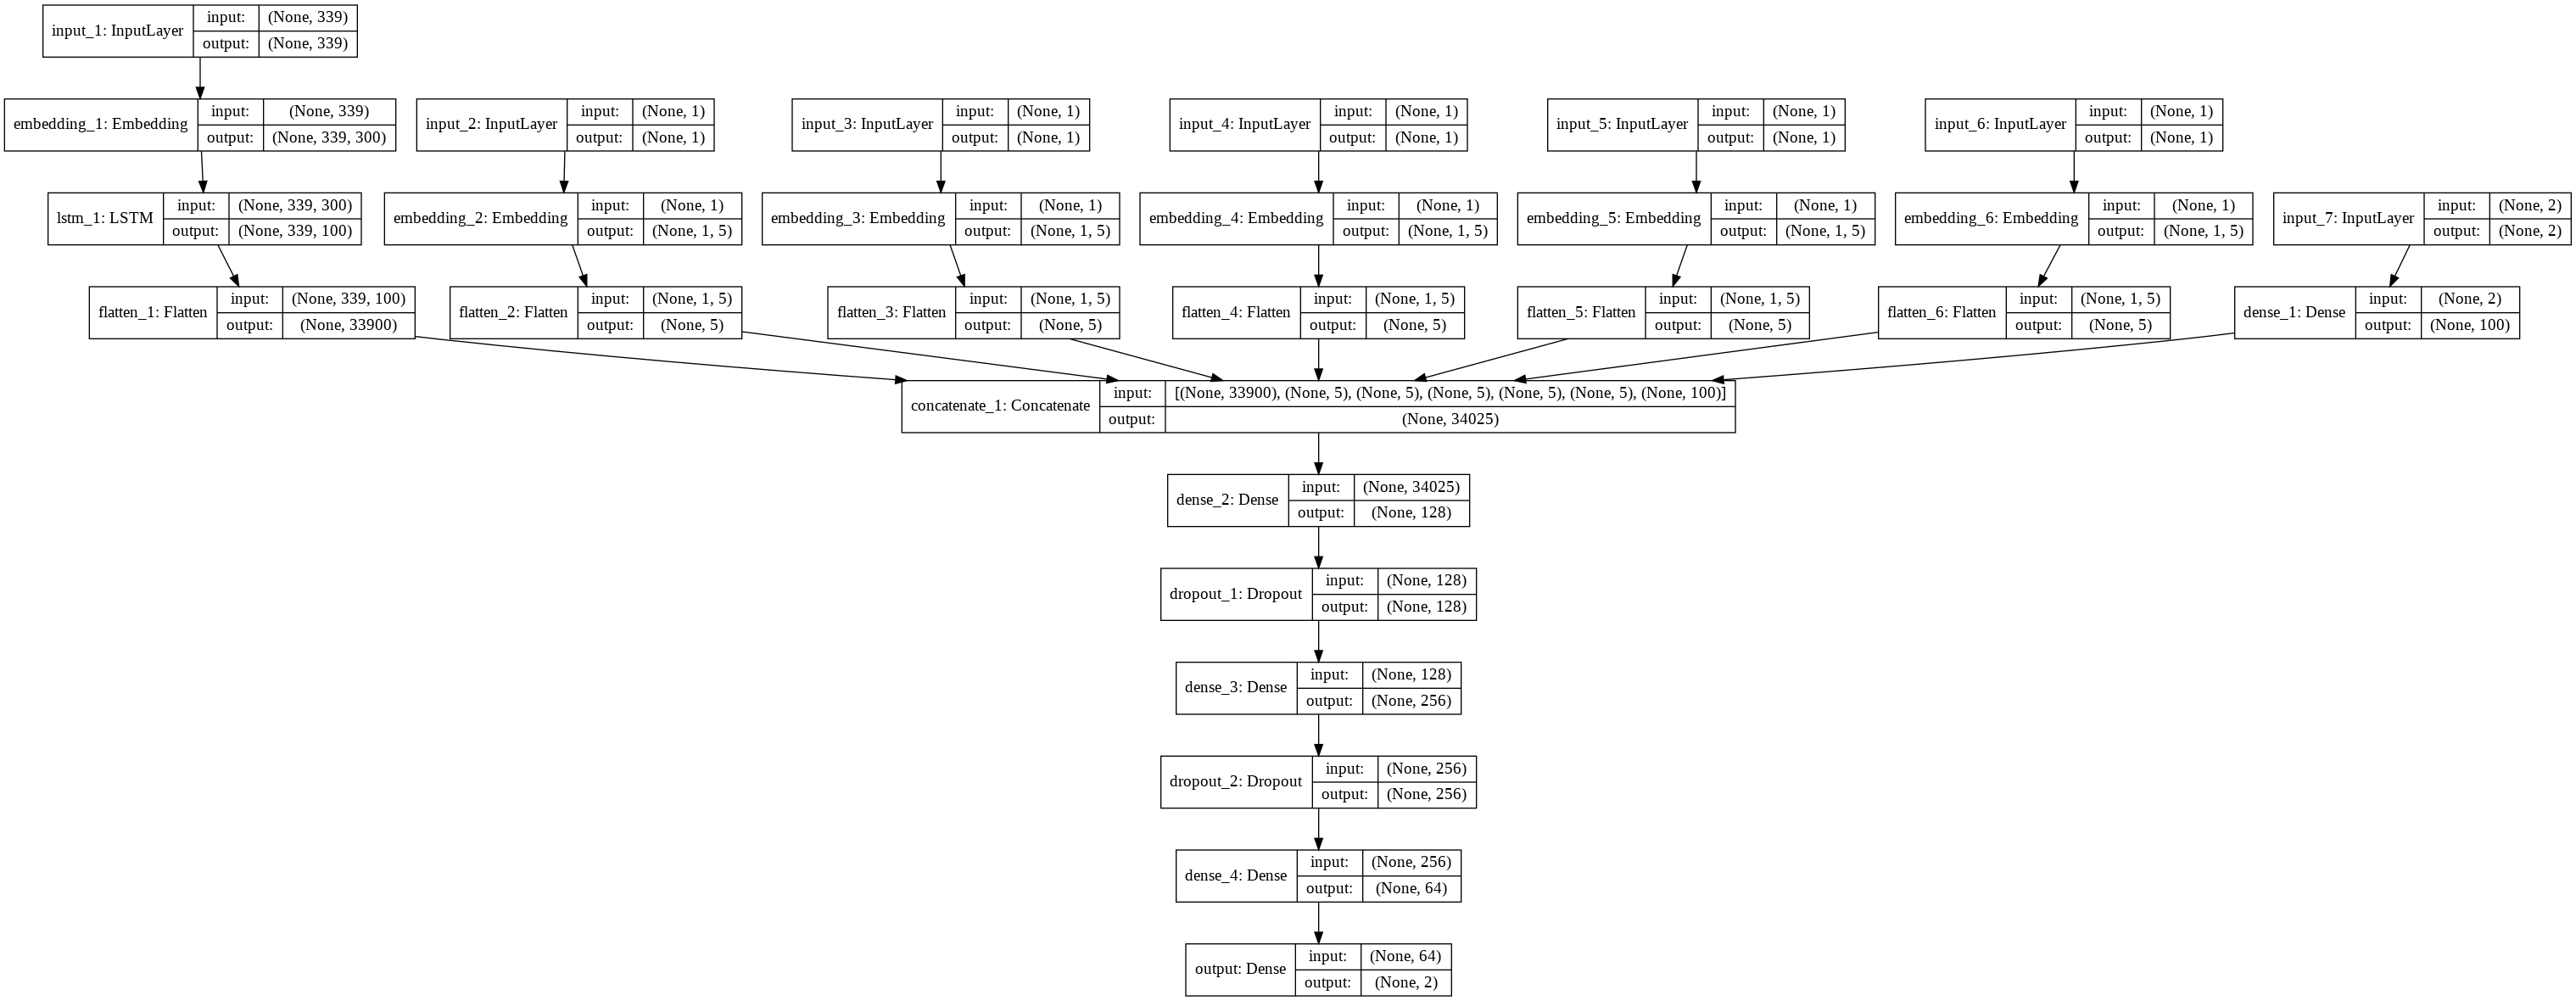

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

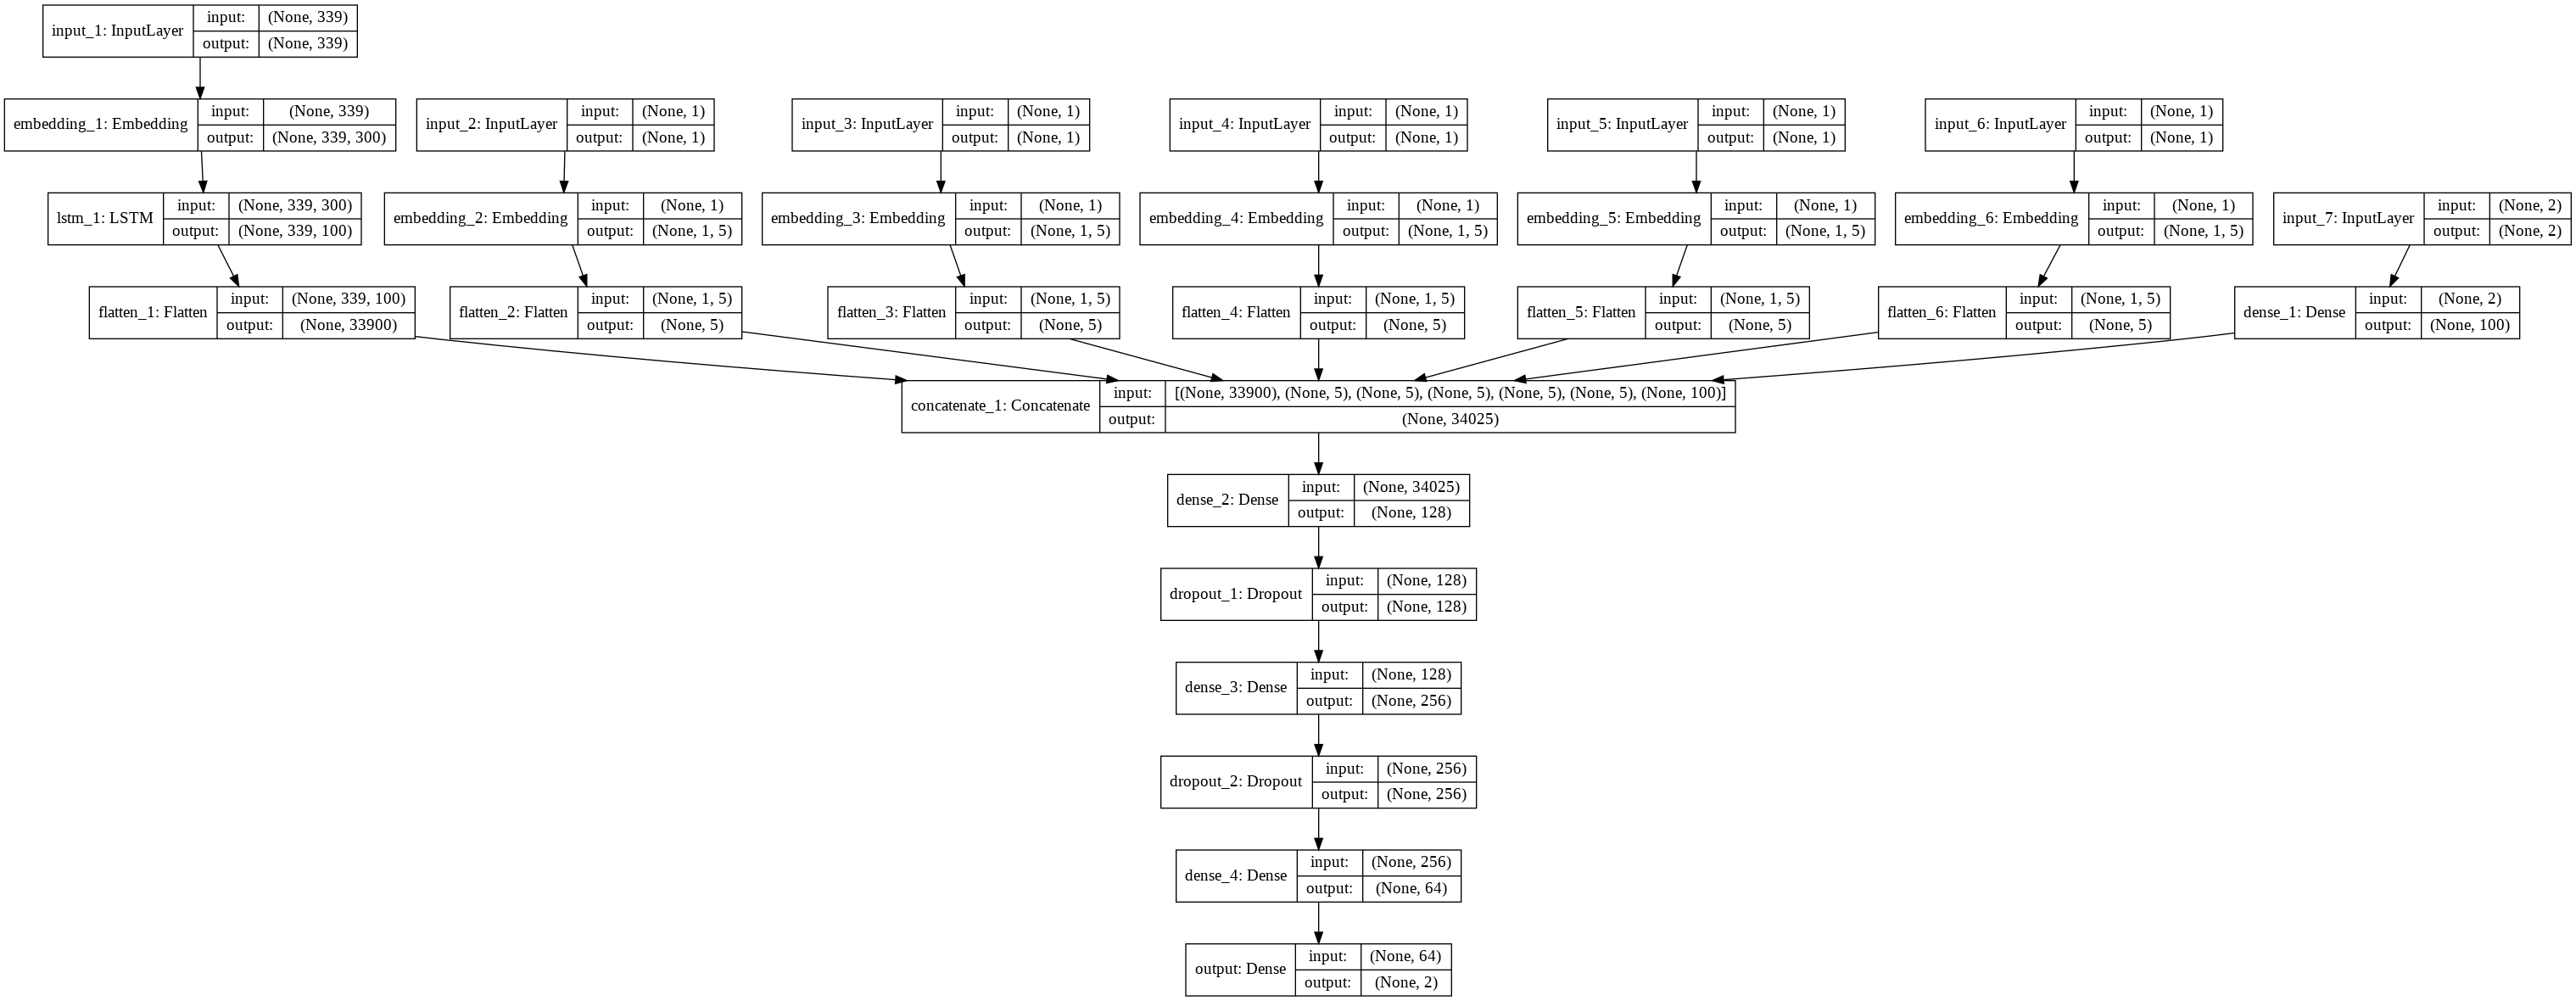

In [0]:
from IPython.display import Image
Image(retina=True, filename='model_1.png')

In [0]:
#Use to convert categorical data into numerical indexes
lb = LabelEncoder()
padded_pre_train = lb.fit_transform(x_train["teacher_prefix"])
padded_pre_test = lb.transform(x_test["teacher_prefix"])
padded_pre_cv = lb.transform(x_cv["teacher_prefix"])

In [0]:
padded_st_train = lb.fit_transform(x_train["school_state"])
padded_st_test = lb.transform(x_test["school_state"])
padded_st_cv = lb.transform(x_cv["school_state"])

In [0]:
padded_grade_train = lb.fit_transform(x_train["project_grade_category"])
padded_grade_test = lb.transform(x_test["project_grade_category"])
padded_grade_cv = lb.transform(x_cv["project_grade_category"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_categories"])
x_test["clean_categories"] = x_test["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_categories"] = x_cv["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_cat_train = le.transform(x_train["clean_categories"])
padded_cat_test= le.transform(x_test["clean_categories"])
padded_cat_cv = le.transform(x_cv["clean_categories"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_subcategories"])
x_test["clean_subcategories"] = x_test["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_subcategories"] = x_cv["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_sub_train = le.transform(x_train["clean_subcategories"])
padded_sub_test= le.transform(x_test["clean_subcategories"])
padded_sub_cv = le.transform(x_cv["clean_subcategories"])

In [0]:
padded_data_train = [padded_essay_train,padded_pre_train,padded_st_train,
              padded_grade_train,padded_cat_train,padded_sub_train,num_train]
padded_data_test = [padded_essay_test,padded_pre_test,padded_st_test,
              padded_grade_test,padded_cat_test,padded_sub_test,num_test]
padded_data_cv = [padded_essay_cv,padded_pre_cv,padded_st_cv,
              padded_grade_cv,padded_cat_cv,padded_sub_cv,num_cv]

In [0]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 2) 
y_cv=np_utils.to_categorical(y_cv, 2) 
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

tensorboard_1 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_1 = ModelCheckpoint("model_1.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb1=[tensorboard_1,checkpoint_1]

In [0]:
trained_model = model_1.fit(padded_data_train,y_train,batch_size=512,epochs=20,validation_data=(padded_data_cv,y_cv),callbacks=callb1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples



Epoch 1/20
69918/69918 [==============================] - 108s 2ms/step - loss: 1.2285 - auc: 0.6514 - val_loss: 0.9808 - val_auc: 0.7210


Epoch 00001: auc improved from -inf to 0.65137, saving model to model_1.h5
Epoch 2/20
69918/69918 [==============================] - 108s 2ms/step - loss: 0.8256 - auc: 0.7330 - val_loss: 0.7816 - val_auc: 0.7390

Epoch 00002: auc improved from 0.65137 to 0.73298, saving model to model_1.h5
Epoch 3/20
69918/69918 [==============================] - 107s 2ms/step - loss: 0.6714 - auc: 0.7576 - val_loss: 0.6693 - val_auc: 0.7491

Epoch 00003: auc improved from 0.73298 to 0.75756, saving model to model_1.h5
Epoch 4/20
69918/69918 [==============================] - 107s 2ms/step - loss: 0.5876 - auc: 0.7770 - val_loss: 0.5812 - val_auc: 0.7534

Epoch 00004: auc improved from 0.75756 to 0.77698, saving model

21850/21850 [==============================] - 13s 598us/step
Test Loss: 1.141558482237757
Test AUC: 0.6768023463558346


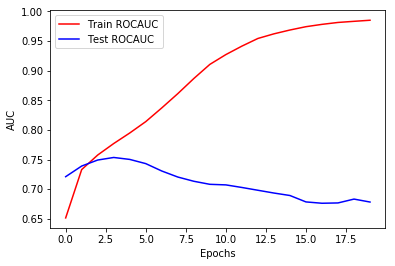

In [0]:
score = model_1.evaluate(padded_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

### Model-2

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
text_tfidf_train = vectorizer_tfidf_essay.fit_transform(x_train['essay'])
text_tfidf_test = vectorizer_tfidf_essay.transform(x_test['essay'])
text_tfidf_cv = vectorizer_tfidf_essay.transform(x_cv['essay'])
print("Shape of matrix after tf-idf encoding ",text_tfidf_train.shape)
print("Shape of matrix after tf-idf encoding ",text_tfidf_test.shape)
print("Shape of matrix after tf-idf encoding ",text_tfidf_cv.shape)

Shape of matrix after tf-idf encoding  (69918, 13969)
Shape of matrix after tf-idf encoding  (21850, 13969)
Shape of matrix after tf-idf encoding  (17480, 13969)


In [0]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer_tfidf_essay.get_feature_names(), list(vectorizer_tfidf_essay.idf_)))

In [0]:
import operator
sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1))
print(sorted_x)

[('students', 1.007882931788298), ('nannan', 1.0454846592481222), ('school', 1.1617477459872698), ('my', 1.2460771924870337), ('learning', 1.36315849698736), ('classroom', 1.3906368769461448), ('not', 1.4478786013748552), ('learn', 1.4616035337076894), ('the', 1.468068975343891), ('they', 1.498351134339453), ('help', 1.5138431823126204), ('many', 1.5789923700444213), ('need', 1.6667951387759539), ('we', 1.7173950916327905), ('work', 1.7244240155059605), ('come', 1.7357322906440134), ('use', 1.7869910236702196), ('able', 1.8323686434394346), ('love', 1.8438094321850704), ('also', 1.8633201167332056), ('day', 1.8660706830122313), ('this', 1.866921153373575), ('class', 1.8842227417991588), ('our', 1.927784036563863), ('make', 1.9392792522669762), ('year', 2.006152317397473), ('new', 2.011643819391148), ('one', 2.025426215773786), ('would', 2.0255857435718427), ('these', 2.0269427583480377), ('student', 2.045689149983933), ('time', 2.045892646046987), ('want', 2.072497089907064), ('skills'

In [0]:
vocab=[]
for i in sorted_x:
    if (i[1]>2 and i[1]<11):
        vocab.append(i[0])

In [0]:
new_essay=[]
for sen in tqdm(x_train['essay'].values):
    sentence=list()
    words=sen.split()
    for word in words:
        if  word in vocab:
            sentence.append(word)
    new=' '.join(sentence)
    new_essay.append(new)

100%|██████████| 69918/69918 [11:36<00:00, 100.43it/s]


In [0]:
new_essay=np.array(new_essay)
corpus=[]
essay_len=[]
cnt=0
for sen in new_essay:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 291
No of unique words  13944


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(new_essay)
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [0]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (69918, 291)


In [0]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (21850, 291)


In [0]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (17480, 291)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding =embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

In [0]:
no_of_unique_state  = x_train["school_state"].nunique()
print('Unique State:', no_of_unique_state)

Unique State: 51


In [0]:
input_state = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_state)
flatten_1=Flatten()(embedding)


In [0]:
no_of_unique_grade  = x_train["project_grade_category"].nunique()
print('Unique Grades:', no_of_unique_grade)

Unique Grades: 4


In [0]:
input_grade = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_grade)
flatten_2=Flatten()(embedding)


In [0]:
no_of_unique_prefix  = x_train["teacher_prefix"].nunique()
print('Unique Prefixes ', no_of_unique_prefix)

Unique Prefixes  5


In [0]:
input_pre = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_pre)
flatten_3=Flatten()(embedding)


In [0]:
no_of_unique_cat  = x_train["clean_categories"].nunique()
print('Unique Categories ', no_of_unique_cat)

Unique Categories  49


In [0]:
input_cat= Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_cat)
flatten_4=Flatten()(embedding)

In [0]:
no_of_unique_sub  = x_train["clean_subcategories"].nunique()
print('Unique SubCategories ', no_of_unique_sub)

Unique SubCategories  386


In [0]:
input_sub = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_sub)
flatten_5=Flatten()(embedding)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
Input_num = Input(shape=(2,))
rem_input = Dense(100,activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(Input_num)

In [0]:
print("Building Model-2")
x_concatenate = concatenate([flatten,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,rem_input])
x = Dense(128, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
x=Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.5)(x)
x = Dense(64, activation='relu',kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)
model_2 = Model(inputs=[input_layer,input_state,input_grade,input_pre,input_cat,input_sub,Input_num],outputs=[output])

Building Model-2

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#Printing Model Summary
print(model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 291)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 291, 300)     4183500     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

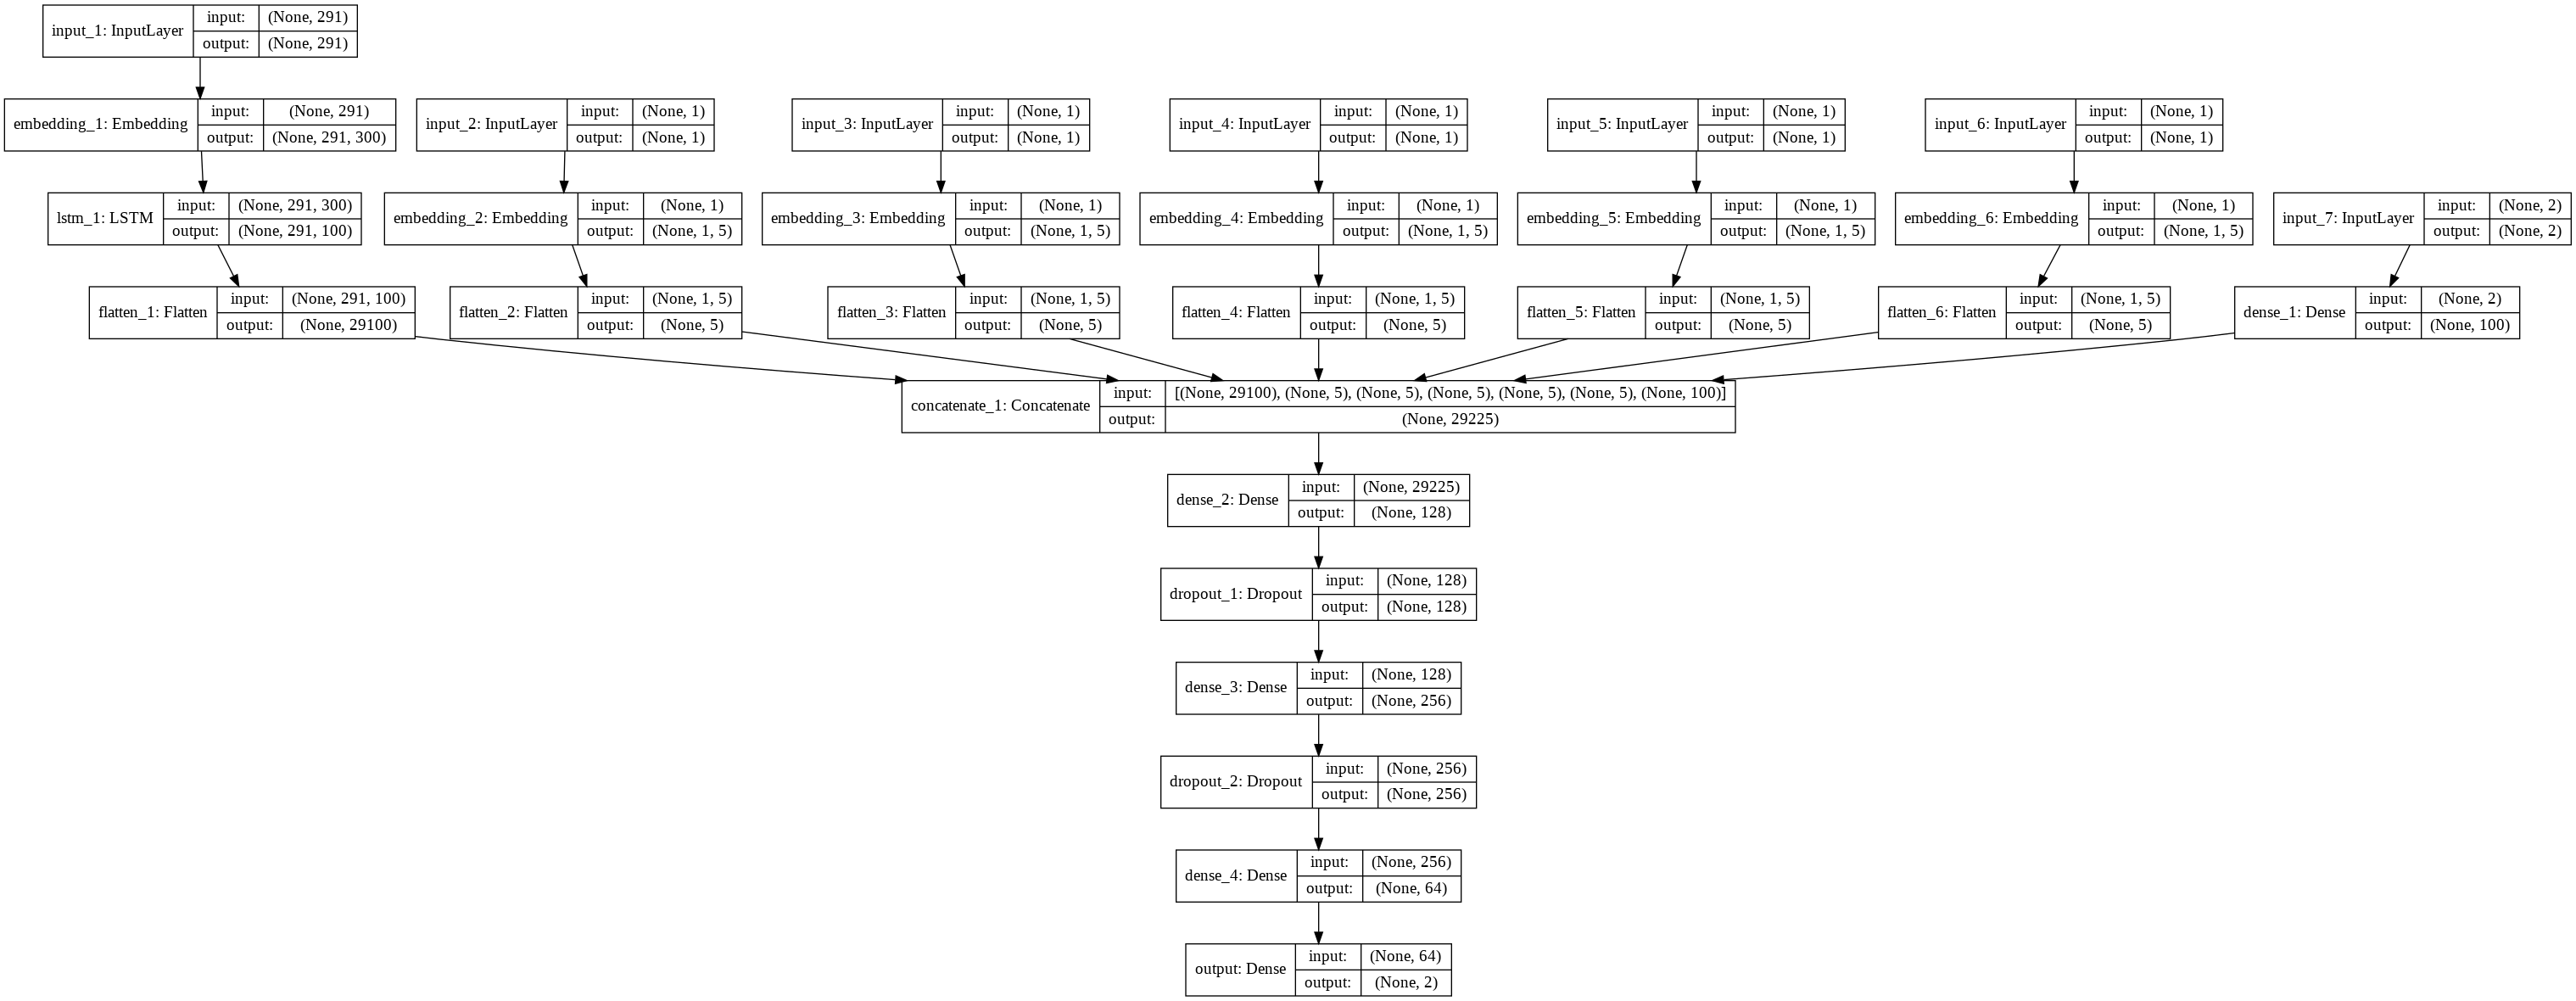

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

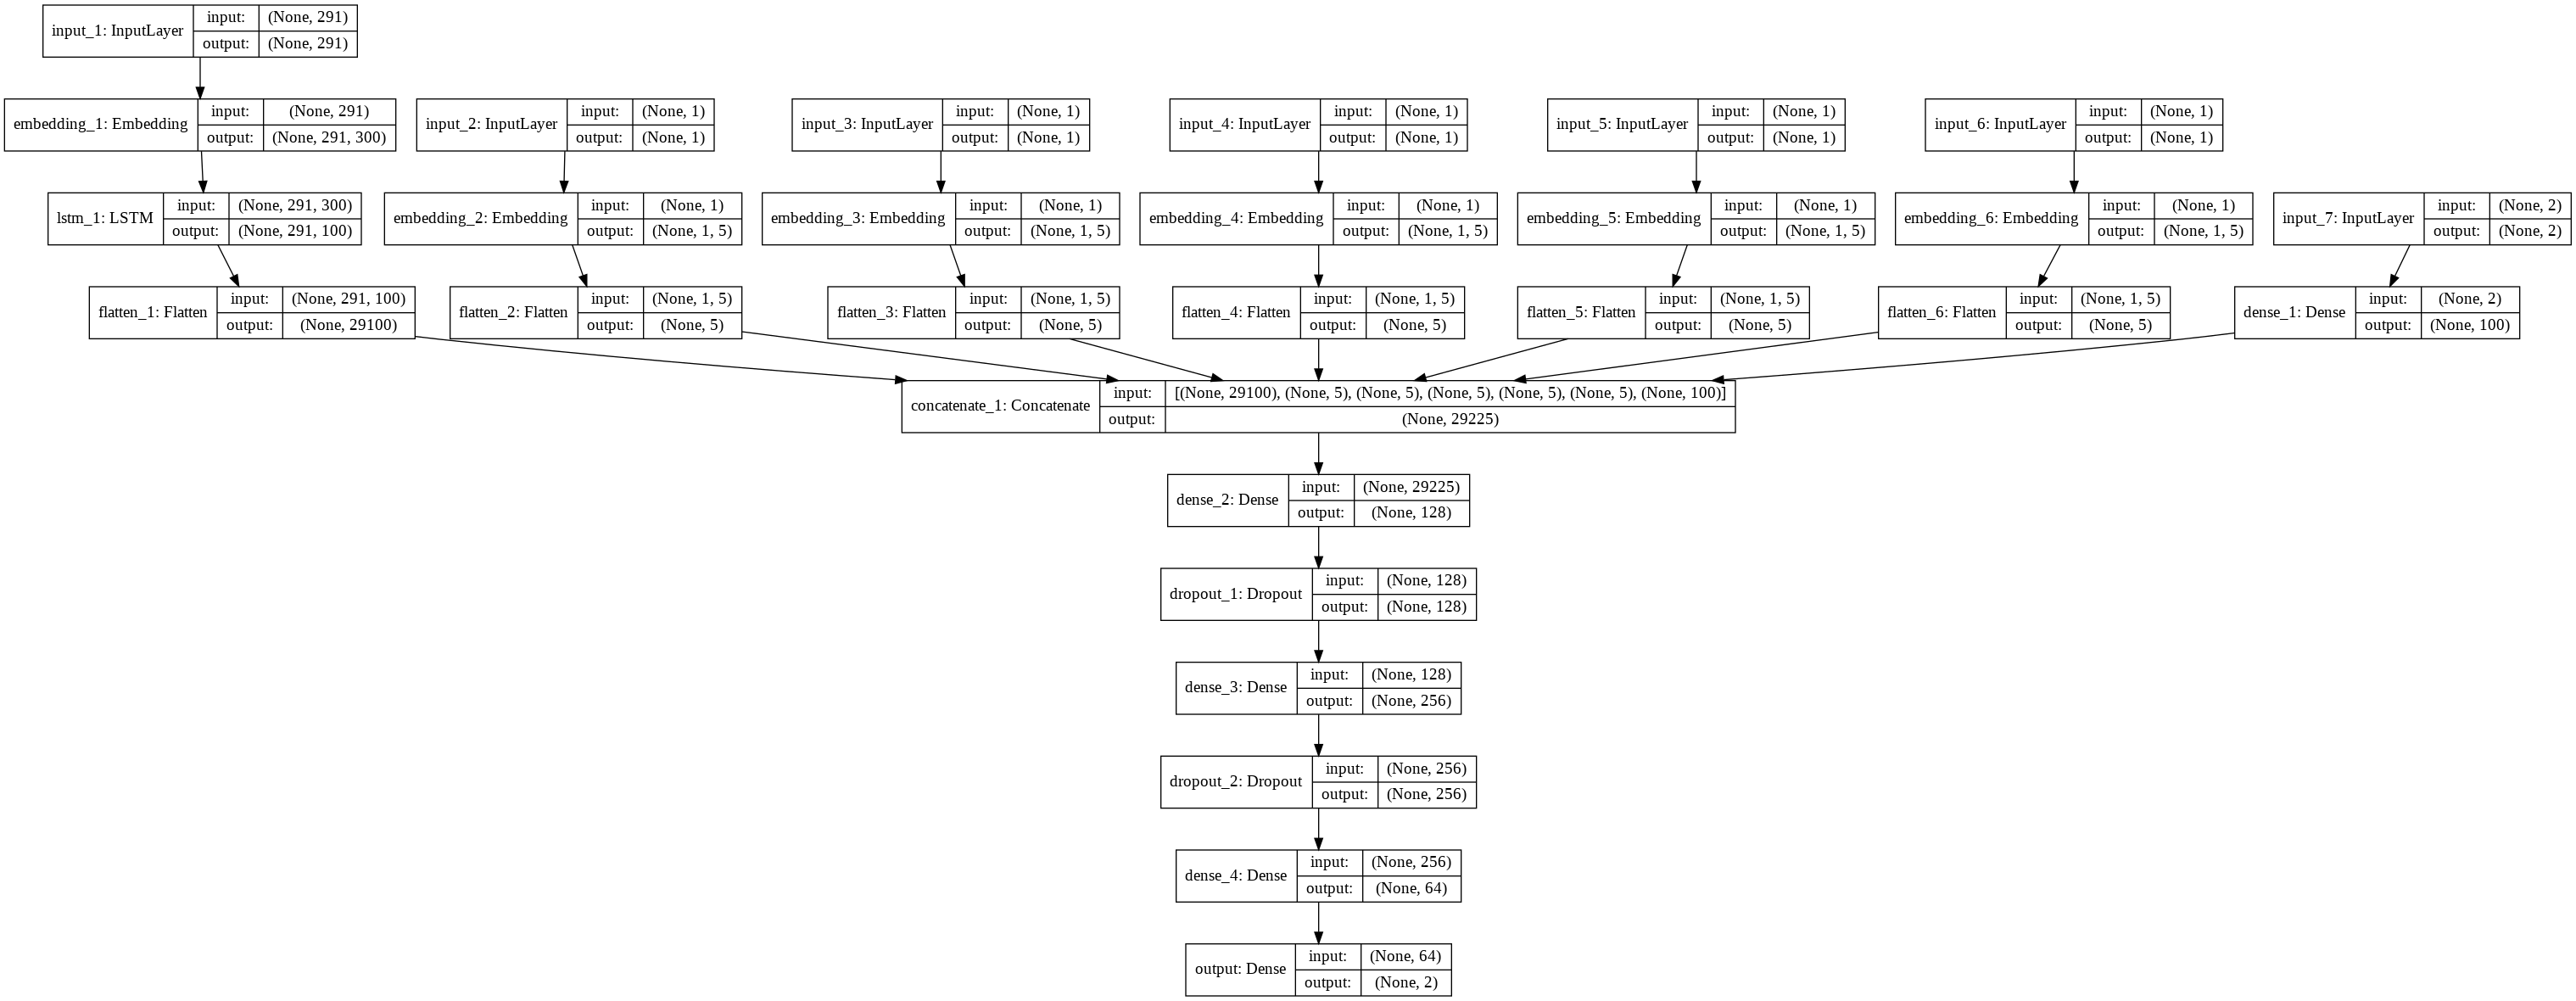

In [0]:
from IPython.display import Image
Image(retina=True, filename='model_2.png')

In [0]:
#Use to convert categorical data into numerical indexes
lb = LabelEncoder()
padded_pre_train = lb.fit_transform(x_train["teacher_prefix"])
padded_pre_test = lb.transform(x_test["teacher_prefix"])
padded_pre_cv = lb.transform(x_cv["teacher_prefix"])

In [0]:
padded_st_train = lb.fit_transform(x_train["school_state"])
padded_st_test = lb.transform(x_test["school_state"])
padded_st_cv = lb.transform(x_cv["school_state"])

In [0]:
padded_grade_train = lb.fit_transform(x_train["project_grade_category"])
padded_grade_test = lb.transform(x_test["project_grade_category"])
padded_grade_cv = lb.transform(x_cv["project_grade_category"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_categories"])
x_test["clean_categories"] = x_test["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_categories"] = x_cv["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_cat_train = le.transform(x_train["clean_categories"])
padded_cat_test= le.transform(x_test["clean_categories"])
padded_cat_cv = le.transform(x_cv["clean_categories"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_subcategories"])
x_test["clean_subcategories"] = x_test["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_subcategories"] = x_cv["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_sub_train = le.transform(x_train["clean_subcategories"])
padded_sub_test= le.transform(x_test["clean_subcategories"])
padded_sub_cv = le.transform(x_cv["clean_subcategories"])

In [0]:
padded_data_train = [padded_essay_train,padded_pre_train,padded_st_train,
              padded_grade_train,padded_cat_train,padded_sub_train,num_train]
padded_data_test = [padded_essay_test,padded_pre_test,padded_st_test,
              padded_grade_test,padded_cat_test,padded_sub_test,num_test]
padded_data_cv = [padded_essay_cv,padded_pre_cv,padded_st_cv,
              padded_grade_cv,padded_cat_cv,padded_sub_cv,num_cv]

In [0]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 2) 
y_cv=np_utils.to_categorical(y_cv, 2) 
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

earlystop_2 = EarlyStopping(monitor = 'val_loss', mode="min",min_delta = 0, patience = 2,verbose = 1,restore_best_weights = True)
tensorboard_2 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_2 = ModelCheckpoint("model_2.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb2=[tensorboard_2,checkpoint_2,earlystop_2]

In [0]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

In [0]:
trained_model = model_2.fit(padded_data_train,y_train,batch_size=512,epochs=20,validation_data=(padded_data_cv,y_cv),callbacks=callb2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples



Epoch 1/20
69918/69918 [==============================] - 91s 1ms/step - loss: 1.1033 - auc: 0.6629 - val_loss: 0.8454 - val_auc: 0.7341


Epoch 00001: auc improved from -inf to 0.66288, saving model to model_2.h5
Epoch 2/20
69918/69918 [==============================] - 90s 1ms/step - loss: 0.7100 - auc: 0.7379 - val_loss: 0.6544 - val_auc: 0.7485

Epoch 00002: auc improved from 0.66288 to 0.73792, saving model to model_2.h5
Epoch 3/20
69918/69918 [==============================] - 89s 1ms/step - loss: 0.5775 - auc: 0.7599 - val_loss: 0.5696 - val_auc: 0.7520

Epoch 00003: auc improved from 0.73792 to 0.75994, saving model to model_2.h5
Epoch 4/20
69918/69918 [==============================] - 90s 1ms/step - loss: 0.5129 - auc: 0.7749 - val_loss: 0.5162 - val_auc: 0.7614

Epoch 00004: auc improved from 0.75994 to 0.77488, saving model to 

21850/21850 [==============================] - 11s 524us/step
Test Loss: 0.49326584416614244
Test AUC: 0.7464376320512204


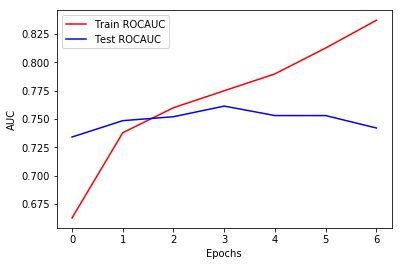

In [0]:
score = model_2.evaluate(padded_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

### Model-3

## input_seq_total_text_data:
  . Use text column('essay'), and use the Embedding layer to get word vectors. 

  . Use given predefined glove word vectors, don't train any word vectors. 

  . Use LSTM that is given above, get the LSTM output and Flatten that output. 

  . You are free to preprocess the input text as you needed. 

## Other_than_text_data:
  . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors 

  . Neumerical values and use CNN1D as shown in above figure. 

  . You are free to choose all CNN parameters like kernel sizes, stride.


In [0]:
corpus=[]
essay_len=[]
cnt=0
for sen in x_train['essay'].values:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 339
No of unique words  47419


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(x_train["essay"])
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [0]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (69918, 339)


In [0]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (21850, 339)


In [0]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (17480, 339)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.15243  , -0.16945  , -0.022748 , ...,  0.61801  ,  0.41281  ,
         0.0010077],
       [-0.043504 , -0.18484  , -0.14613  , ...,  0.1008   ,  0.1068   ,
         0.089065 ],
       ...,
       [ 0.28537  ,  0.079893 ,  0.15979  , ..., -0.18343  ,  0.47576  ,
         0.54564  ],
       [-0.078014 , -0.31444  ,  0.3376   , ...,  0.091821 , -1.0056   ,
        -0.82065  ],
       [-0.11057  , -0.067981 ,  0.22746  , ..., -0.50917  ,  0.40218  ,
        -0.15479  ]])

In [0]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding = embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

In [0]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
cat_vocab=set(x_train['clean_categories'].values)
vectorizer = CountVectorizer(vocabulary=list(cat_vocab), lowercase=False, binary=True)
categories_one_hot_train = vectorizer.fit_transform(x_train['clean_categories'].values)
print("Shape of matrix after one hot encoding ",categories_one_hot_train.shape)

Shape of matrix after one hot encoding  (69918, 51)


In [0]:
categories_one_hot_test = vectorizer.transform(x_test['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encoding ",categories_one_hot_test.shape)

['health_sports math_science', 'health_sports specialneeds', 'math_science appliedlearning', 'music_arts specialneeds', 'history_civics appliedlearning', 'literacy_language', 'math_science literacy_language', 'history_civics specialneeds', 'history_civics', 'literacy_language warmth care_hunger', 'math_science history_civics', 'warmth care_hunger', 'music_arts health_sports', 'specialneeds music_arts', 'specialneeds warmth care_hunger', 'math_science', 'specialneeds health_sports', 'music_arts appliedlearning', 'appliedlearning music_arts', 'math_science warmth care_hunger', 'literacy_language specialneeds', 'history_civics math_science', 'music_arts', 'literacy_language music_arts', 'history_civics literacy_language', 'literacy_language history_civics', 'health_sports warmth care_hunger', 'music_arts history_civics', 'health_sports music_arts', 'literacy_language math_science', 'health_sports', 'appliedlearning history_civics', 'history_civics music_arts', 'appliedlearning warmth care

In [0]:
categories_one_hot_cv = vectorizer.transform(x_cv['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encoding ",categories_one_hot_cv.shape)

['health_sports math_science', 'health_sports specialneeds', 'math_science appliedlearning', 'music_arts specialneeds', 'history_civics appliedlearning', 'literacy_language', 'math_science literacy_language', 'history_civics specialneeds', 'history_civics', 'literacy_language warmth care_hunger', 'math_science history_civics', 'warmth care_hunger', 'music_arts health_sports', 'specialneeds music_arts', 'specialneeds warmth care_hunger', 'math_science', 'specialneeds health_sports', 'music_arts appliedlearning', 'appliedlearning music_arts', 'math_science warmth care_hunger', 'literacy_language specialneeds', 'history_civics math_science', 'music_arts', 'literacy_language music_arts', 'history_civics literacy_language', 'literacy_language history_civics', 'health_sports warmth care_hunger', 'music_arts history_civics', 'health_sports music_arts', 'literacy_language math_science', 'health_sports', 'appliedlearning history_civics', 'history_civics music_arts', 'appliedlearning warmth care

In [0]:
# we use count vectorizer to convert the values into one 
subcat_vocab=set(x_train['clean_subcategories'].values)
vectorizer = CountVectorizer(vocabulary=list(subcat_vocab), lowercase=False, binary=True)
subcategories_one_hot_train = vectorizer.fit_transform(x_train['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_train.shape)

Shape of matrix after one hot encoding  (69918, 391)


In [0]:
subcategories_one_hot_test = vectorizer.transform(x_test['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_test.shape)

Shape of matrix after one hot encoding  (21850, 391)


In [0]:
subcategories_one_hot_cv = vectorizer.transform(x_cv['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_cv.shape)

Shape of matrix after one hot encoding  (17480, 391)


In [0]:
# we use count vectorizer to convert the values into one 
state_vocab=set(x_train['school_state'].values)
vectorizer = CountVectorizer(vocabulary=list(state_vocab), lowercase=False, binary=True)
state_one_hot_train=vectorizer.fit_transform(x_train['school_state'].values)
state_one_hot_test=vectorizer.transform(x_test['school_state'].values)
state_one_hot_cv=vectorizer.transform(x_cv['school_state'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",state_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",state_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",state_one_hot_cv.shape)

['fl', 'mi', 'sc', 'il', 'in', 'pa', 'mo', 'wi', 'vt', 'ct', 'ms', 'ak', 'la', 'ny', 'al', 'oh', 'wv', 'nd', 'de', 'id', 'tx', 'va', 'ga', 'ut', 'tn', 'nj', 'nh', 'mn', 'mt', 'ks', 'az', 'ia', 'ri', 'ne', 'wa', 'sd', 'co', 'ky', 'dc', 'nv', 'nc', 'ar', 'hi', 'md', 'ok', 'wy', 'ca', 'ma', 'nm', 'or', 'me']
Shape of matrix after one hot encoding  (69918, 51)
Shape of matrix after one hot encoding  (21850, 51)
Shape of matrix after one hot encoding  (17480, 51)


In [0]:
grade_vocab=set(x_train['project_grade_category'].values)
vectorizer = CountVectorizer(vocabulary=list(grade_vocab), lowercase=False, binary=True)
grade_one_hot_train=vectorizer.fit_transform(x_train['project_grade_category'].values)
grade_one_hot_test=vectorizer.transform(x_test['project_grade_category'].values)
grade_one_hot_cv=vectorizer.transform(x_cv['project_grade_category'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",grade_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_cv.shape)

['grades_9_12', 'grades_prek_2', 'grades_3_5', 'grades_6_8']
Shape of matrix after one hot encoding  (69918, 4)
Shape of matrix after one hot encoding  (21850, 4)
Shape of matrix after one hot encoding  (17480, 4)


In [0]:
prefix_vocab=set(x_train['teacher_prefix'].values)
vectorizer = CountVectorizer(vocabulary=list(prefix_vocab), lowercase=False, binary=True)
teacher_one_hot_train=vectorizer.fit_transform(x_train['teacher_prefix'].values)
teacher_one_hot_test=vectorizer.transform(x_test['teacher_prefix'].values)
teacher_one_hot_cv=vectorizer.transform(x_cv['teacher_prefix'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",teacher_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",teacher_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",teacher_one_hot_cv.shape)

['teacher', 'mr', 'dr', 'ms', 'mrs']
Shape of matrix after one hot encoding  (69918, 5)
Shape of matrix after one hot encoding  (21850, 5)
Shape of matrix after one hot encoding  (17480, 5)


In [0]:
from scipy.sparse import hstack

categorical_train =hstack((categories_one_hot_train,subcategories_one_hot_train,state_one_hot_train,grade_one_hot_train,teacher_one_hot_train))
categorical_test = hstack((categories_one_hot_test,subcategories_one_hot_test,state_one_hot_test,grade_one_hot_test,teacher_one_hot_test))
categorical_cv = hstack((categories_one_hot_cv,subcategories_one_hot_cv,state_one_hot_cv,grade_one_hot_cv,teacher_one_hot_cv))

In [0]:
print(categorical_train.shape)
print(categorical_test.shape)
print(categorical_cv.shape)

(69918, 502)
(21850, 502)
(17480, 502)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
other_train = hstack((categorical_train,num_train)).todense()
other_test = hstack((categorical_test,num_test)).todense()
other_cv = hstack((categorical_cv,num_cv)).todense()

In [0]:
from numpy import newaxis
other_train=other_train[:,:,newaxis]
other_test=other_test[:,:,newaxis]
other_cv=other_cv[:,:,newaxis]

In [0]:
input_cat=Input(shape=(other_train.shape[1],1))
conv1=Conv1D(64,kernel_size=(3),activation='relu',kernel_initializer="he_normal")(input_cat)
conv2=Conv1D(64,kernel_size=(3),activation='relu',kernel_initializer="he_normal")(conv1)
flatten1 = Flatten()(conv2)

In [0]:
concat=concatenate([flatten,flatten1])
d1=Dense(128,activation='relu')(concat)
d2=Dropout(0.5)(d1)
x = Dense(64, activation='relu',kernel_initializer="he_normal")(d2)
x=Dropout(0.7)(x)
d3 = Dense(32, activation='relu',kernel_initializer="he_normal")(x)
output = Dense(2, activation='softmax', name='output')(d3)
model_3 = Model(inputs=[input_layer,input_cat],outputs=[output])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
print(model_3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 339)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 504, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 339, 300)     14226000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 502, 64)      256         input_2[0][0]                    
____________________________________________________________________________________________

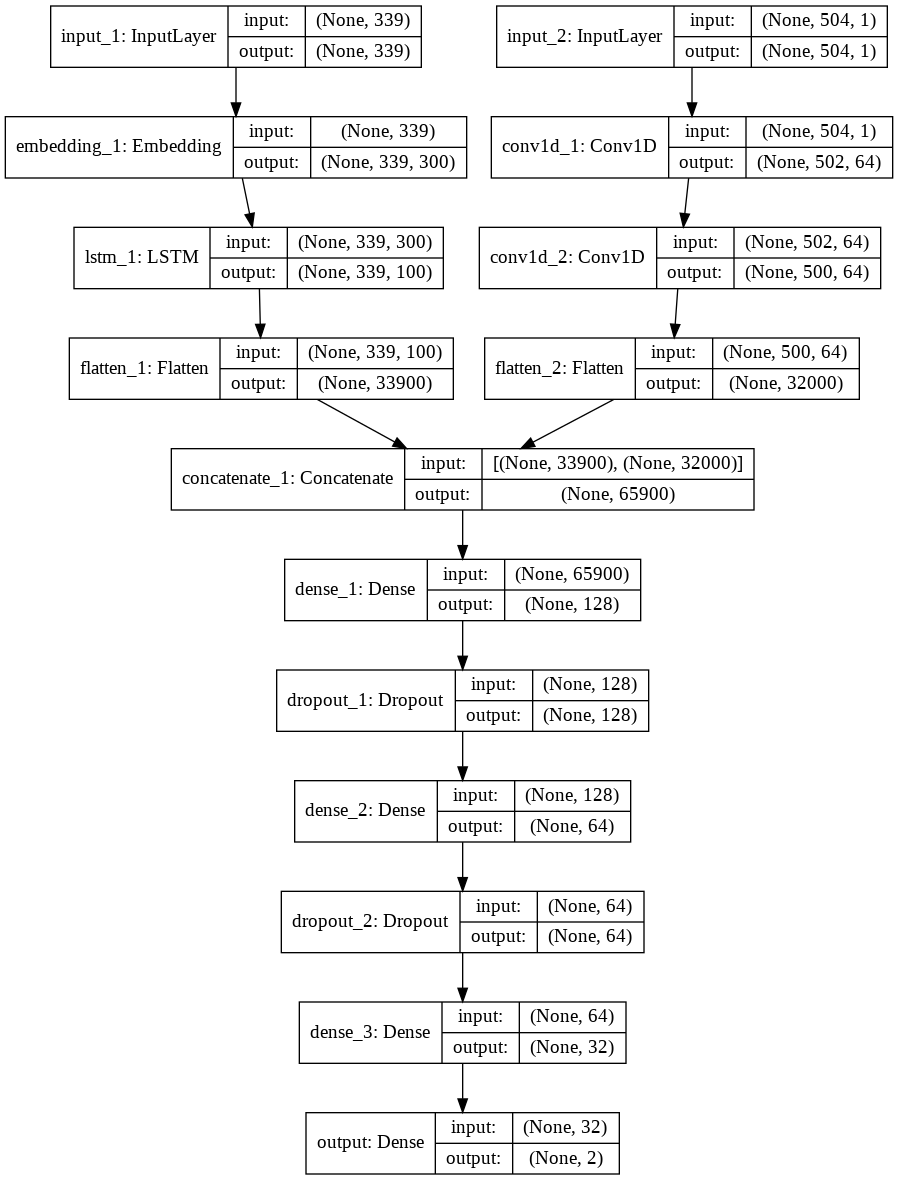

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='model_3.png', show_shapes=True, show_layer_names=True)

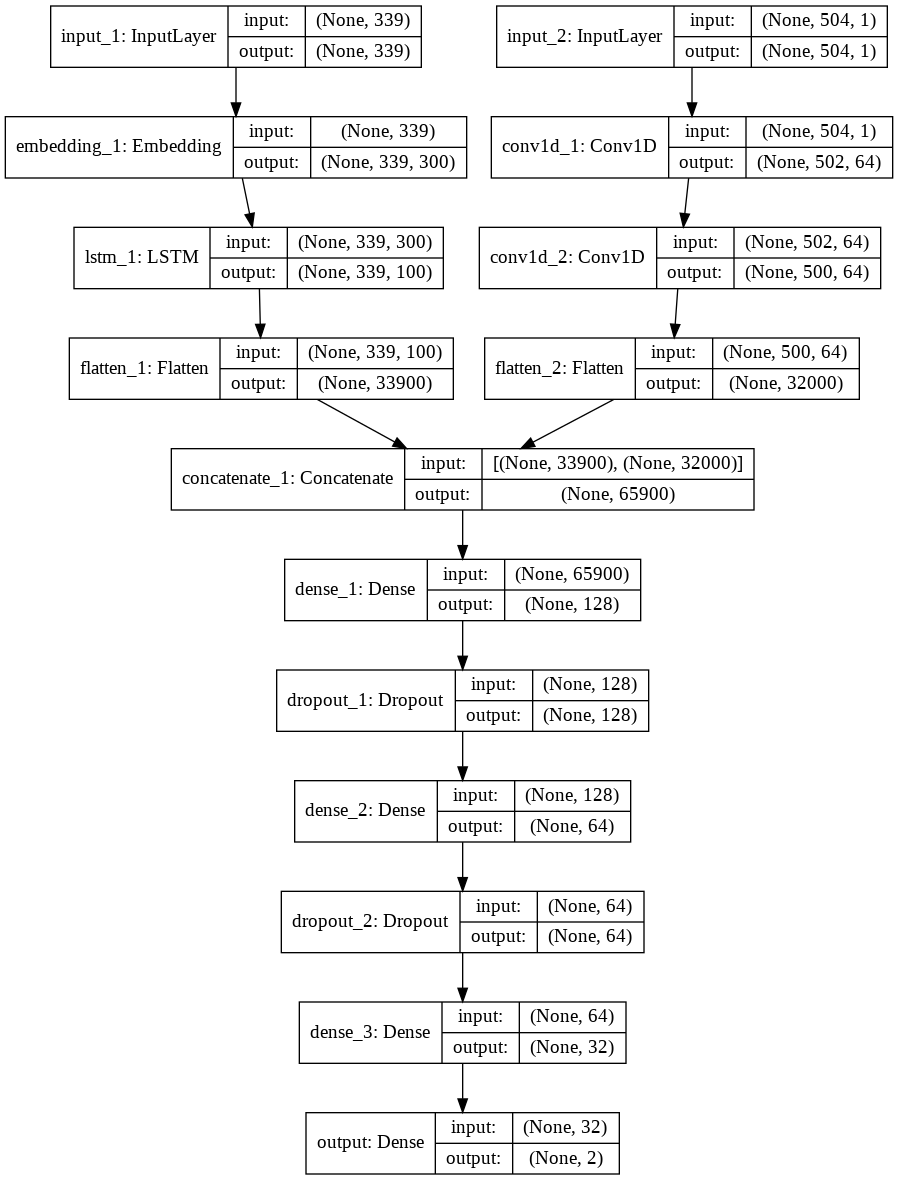

In [0]:
from IPython.display import Image
Image(retina=True, filename='model_3.png')

In [0]:
final_data_train=[padded_essay_train,other_train]
final_data_test=[padded_essay_test,other_test]
final_data_cv=[padded_essay_cv,other_cv]

In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

earlystop_3 = EarlyStopping(monitor = 'val_loss', mode="min",min_delta = 0, patience = 2,verbose = 1,restore_best_weights = True)
tensorboard_3 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_3 = ModelCheckpoint("model_3.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb3=[tensorboard_3,checkpoint_3,earlystop_3]

In [0]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
trained_model = model_3.fit(final_data_train,y_train,batch_size=512,epochs=10,validation_data=(final_data_cv,y_cv),callbacks=callb3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples



Epoch 1/10
69918/69918 [==============================] - 115s 2ms/step - loss: 0.4624 - auc: 0.6125 - val_loss: 0.4305 - val_auc: 0.7210


Epoch 00001: auc improved from -inf to 0.61247, saving model to model_3.h5
Epoch 2/10
69918/69918 [==============================] - 111s 2ms/step - loss: 0.3972 - auc: 0.7078 - val_loss: 0.4280 - val_auc: 0.7428

Epoch 00002: auc improved from 0.61247 to 0.70784, saving model to model_3.h5
Epoch 3/10
69918/69918 [==============================] - 111s 2ms/step - loss: 0.3822 - auc: 0.7408 - val_loss: 0.4148 - val_auc: 0.7527
Epoch 4/10
69918/69918 [==============================] - 110s 2ms/step - loss: 0.3653 - auc: 0.7705 - val_loss: 0.3978 - val_auc: 0.7471

Epoch 00004: auc improved from 0.74080 to 0.77050, saving model to model_3.h5
Epoch 5/10
69918/69918 [==============================] - 110s 2

21850/21850 [==============================] - 14s 621us/step
Test Loss: 0.39724937580542924
Test AUC: 0.7493482358600704


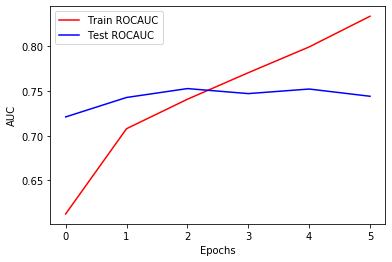

In [0]:
score = model_3.evaluate(final_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

In [2]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model","val_loss","test_auc"]

x.add_row(["Model_1", 0.5437 ,0.7501])
x.add_row(["Model_2", 0.5022 ,0.7530])
x.add_row(["Model_3", 0.4148 ,0.7527])


print(x)

+---------+----------+----------+
|  Model  | val_loss | test_auc |
+---------+----------+----------+
| Model_1 |  0.5437  |  0.7501  |
| Model_2 |  0.5022  |  0.753   |
| Model_3 |  0.4148  |  0.7527  |
+---------+----------+----------+
